<a href="https://colab.research.google.com/github/LongNguyen1984/DeepLearning/blob/master/SHAPexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install shap package
!pip install shap

#https://nbviewer.jupyter.org/github/kinokoberuji/Statistics-Python-Tutorials/blob/master/shap%20multiclass.ipynb?fbclid=IwAR1tuGf-uXnxVPD-RX0kZDtISp5YkgYjaJnfreEPJd1FQD7RTHD5Mchn3oM

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

#LOOCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

#RF
from sklearn.ensemble import RandomForestClassifier

# Confusion matrix
import itertools
from itertools import cycle
from numpy import where

# SHAP
import shap
shap.initjs()

In [6]:
df = pd.read_csv('https://www.openml.org/data/get_csv/1593719/phpOkU53r.csv')

feat_names=['pelvic_incidence',
            'pelvic_tilt',
            'lumbar_lordosis_angle',
            'sacral_slope',
            'pelvic_radius',
            'spondylolisthesis_grade']

labs = ['Disk_Hernia', 'Normal', 'Spondylolisthesis']

lab_dict = {k:v for k, v in zip([1,2,3], labs)}

df

,V1,V2,V3,V4,V5,V6,Class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985136,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,2
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,2
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,2
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,2


In [7]:
df.shape

(310, 7)

# Data Mining

In [8]:
df.groupby('Class').describe(percentiles = [0.05, 0.5, 0.95]).T

Class              1           2           3
V1 count   60.000000  100.000000  150.000000
   mean    47.638407   51.685244   71.514224
   std     10.697131   12.368161   15.109337
   min     26.147921   30.741938   37.903910
   5%      31.273831   34.636541   45.152469
   50%     46.416169   50.123116   72.149306
   95%     66.976851   73.036113   91.775403
   max     74.433593   89.834676  129.834041
V2 count   60.000000  100.000000  150.000000
   mean    17.398795   12.821414   20.748038
   std      7.016708    6.778503   11.506169
   min      3.144669   -5.845994   -6.554948
   5%       7.443564    1.040521    4.833054
   50%     16.949285   13.482435   19.309548
   95%     28.893082   22.717116   40.844162
   max     41.557331   29.894119   49.431864
V3 count   60.000000  100.000000  150.000000
   mean    35.463524   43.542605   64.110108
   std      9.767795   12.361388   16.397068
   min     14.000000   19.071075   24.710274
   5%      19.808860   26.199988   40.888184
   50%     35.164873   42.638923   62.555200
   95%     50.287584   63.167549   91.762129
   max     62.275275   90.563461  125.742386
V4 count   60.000000  100.000000  150.000000
   mean    30.239612   38.863830   50.766186
   std      7.555388    9.624004   12.318813
   min     13.366931   17.386972   19.290046
   5%      16.216618   23.410802   33.675218
   50%     30.000659   37.059694   50.751695
   95%     42.061476   53.495395   67.177487
   max     46.613539   67.195460  121.429566
V5 count   60.000000  100.000000  150.000000
   mean   116.474968  123.890834  114.518810
   std      9.355720    9.014246   15.579995
   min     84.241415  100.501192   70.082575
   5%      98.769465  110.482398   89.934854
   50%    116.696146  123.874328  114.842400
   95%    130.424714  139.152371  141.040252
   max    137.540613  147.894637  163.071041
V6 count   60.000000  100.000000  150.000000
   mean     2.480251    2.186572   51.896687
   std      5.531177    6.307483   40.108030
   min    -10.675871  -11.058179    1.010041
   5%      -7.913149   -5.147777   20.672078
   50%      2.542441    1.152710   42.372510
   95%     11.224108   12.447626  103.446177
   max     15.779697   31.172767  418.543082

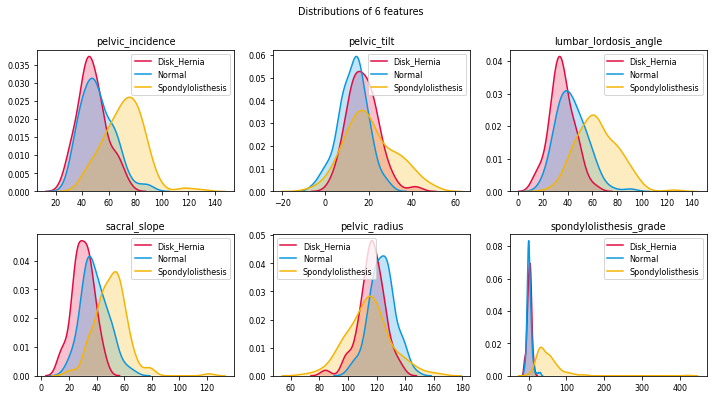

In [10]:
sns.set_palette(sns.color_palette(['#e00b41','#0b96e0','#f5b402']))

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams.update({'font.size':8})

fig, axes = plt.subplots(nrows = 2, ncols=3)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Distributions of 6 features')

for ax, feature, name in zip(axes.flatten(),
                              list(df.drop(['Class'], axis = 1).columns),
                             feat_names):
  ax.set(title=name)
  for i in range(len((labs))):
    sns.kdeplot(data = df[df['Class'] == i+1][feature].values,
                label = lab_dict[i+1],
                shade = True,
                ax = ax)

# Model Regression with SHAP

In [11]:
rf_mod = RandomForestClassifier(n_estimators = 500,
                                  max_depth = 5,
                                criterion = 'gini',
                                n_jobs = -1,
                                random_state = 123)

In [12]:
data = df.values
X, y = data[:, :-1], data [:, -1]


In [13]:
cv = LeaveOneOut()

In [14]:
scores = cross_val_score(rf_mod, 
                         X, y,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1)
scores.mean()

0.8354838709677419

In [19]:
rf_mod.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

# Shap for model
## model = [k x n]
## with  k: number of class
##       n: observations
## Expected value is a list of k predict scores

In [24]:
explainer = shap.TreeExplainer(rf_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

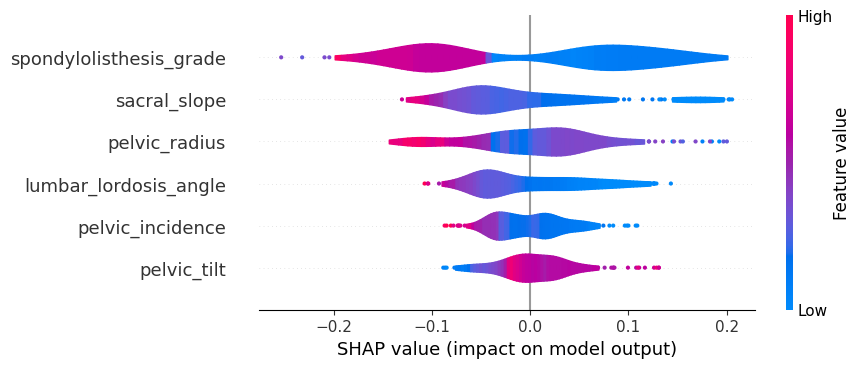

In [29]:
plt.rcParams['figure.figsize'] = [4,6]
plt.rcParams['figure.dpi']= 100

# Normal
shap.summary_plot(shap_values[0], # Class Normal (index 1 trong label list)
                  X, 
                  feature_names = feat_names,
                  plot_type = "violin",
                  show = True,
                  sort = True,
                  auto_size_plot= True)

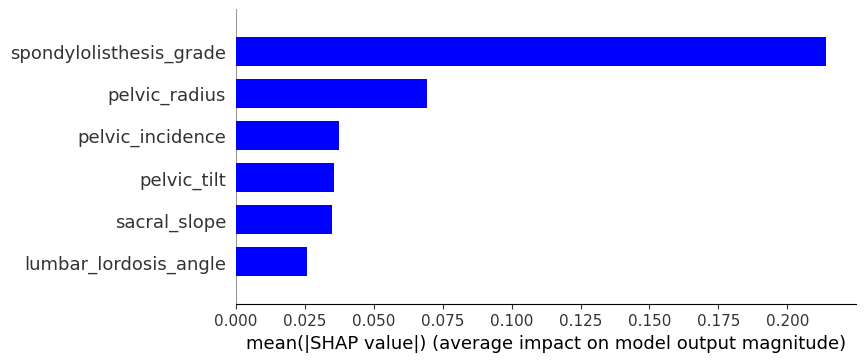

In [30]:
shap.summary_plot(shap_values[1], 
                  X, 
                  feature_names = feat_names,
                  plot_type = "bar",
                  color = 'blue',
                  show = True,
                  sort = True,
                  auto_size_plot= True)

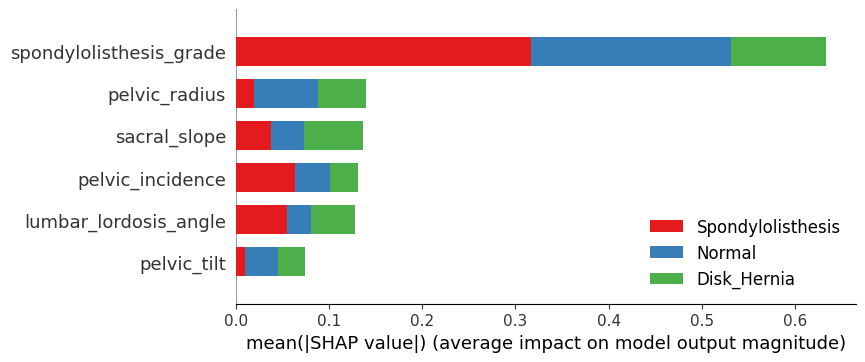

In [31]:
shap.summary_plot(shap_values, 
                  X, 
                  feature_names = feat_names,
                  plot_type = "bar",
                  show = True,
                  sort = True,
                  auto_size_plot= True,
                  class_names=labs,
                  color = cm.Set1,)

# Decision plot

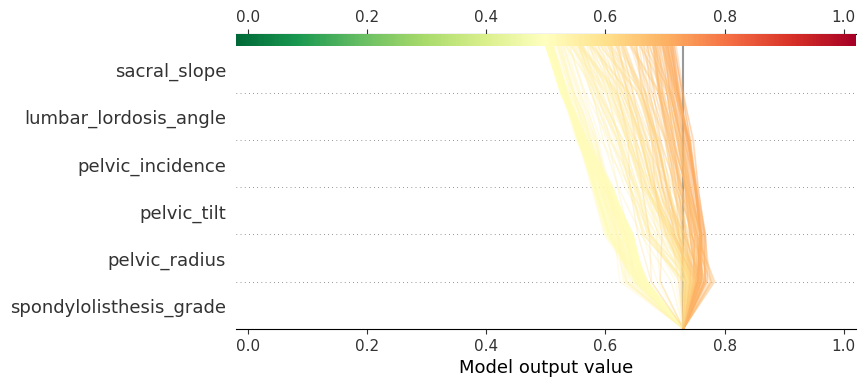

In [32]:
shap.decision_plot(base_value = expected_value[1], 
                   shap_values = shap_values[1], 
                   feature_order='hclust',
                   feature_names = feat_names,
                   features = X,
                   plot_color= cm.RdYlGn_r,
                   alpha = 0.3,
                   link='logit',
                  new_base_value = True)

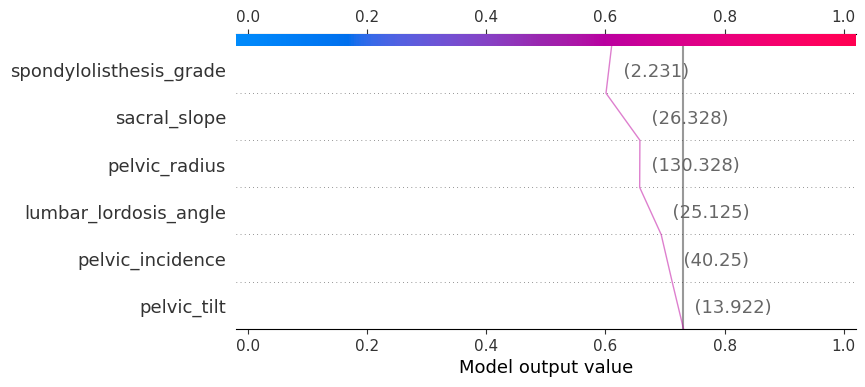

In [35]:

case = 5

shap.decision_plot(base_value = expected_value[1], 
                   shap_values = shap_values[1][case], 
                   feature_order='importance',
                   feature_names = feat_names,
                   features = X[case],
                   alpha = 0.5,
                   link='logit',
                  new_base_value = True)

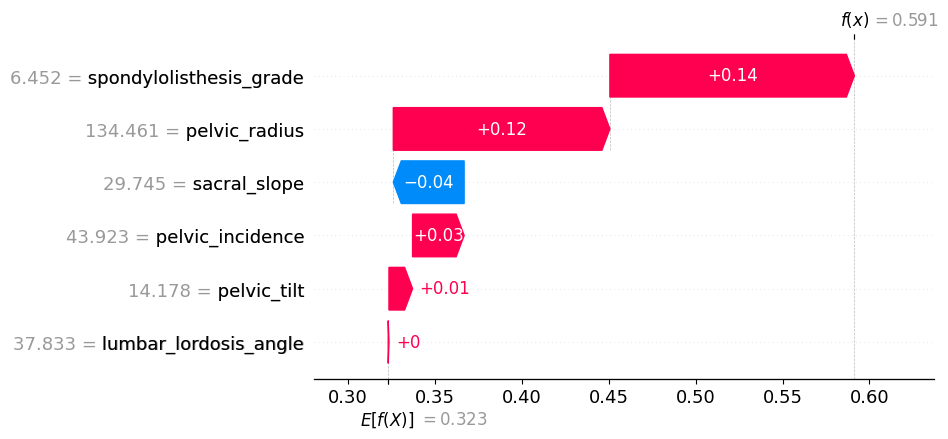

In [41]:
# waterfall chart
case = 20

shap.waterfall_plot(
    expected_value[1],
    shap_values[1][case],
    features=X[case],
    feature_names=feat_names,
    show=True)

# Force Plot


In [45]:
case = 10
# load initjs() to use in notebook.js
shap.initjs()
shap.force_plot(base_value = expected_value[1], 
                shap_values = shap_values[1][case],
                features =  X[case],
                feature_names = feat_names,
                out_names = labs,
                link = 'logit',
                figsize = (10,15))

In [44]:
shap.initjs()
shap.force_plot(base_value = expected_value[1], 
                shap_values = shap_values[1],
                features =  X,
                feature_names = feat_names,
                link = 'logit',
                figsize = (10,15))